In [111]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
from google.cloud import language_v1
import io
import os

# 1. Data Cleaning

In [38]:
# read data
data_test = pd.read_csv('religious_text_test.csv')
data_train = pd.read_csv('religious_text_train.csv')

In [39]:
# fill missing values
data_train[:] = data_train.fillna(0)
data_test[:] = data_test.fillna(0)

# rename the unnamed column to Chapters, '# foolishness' to just foolishness
data_train.rename(columns = {'Unnamed: 0' : 'Chapters'}, inplace = True)
data_test.rename(columns = {'# foolishness' : 'foolishness'}, inplace = True)

# make sure everything is an integer
data_test = data_test.applymap(int).astype(int)
data_train.iloc[:, 1:] = data_train.iloc[:, 1:].applymap(int).astype(int)

In [40]:
# Data validation stuff, more cleaning

all(data_train.iloc[:,1:].dtypes == 'int64') # True (All entries are integers)
all(data_test.dtypes == 'int64') # True (All entries are integers)

all(list(map(lambda a: ' ' not in a, data_train.iloc[:,1:].columns))) # Each column is one word
all(list(map(lambda a: ' ' not in a, data_test.columns))) # Each column is one word

True

In [41]:
# Extraaaaaa way of getting the books lmao, dont do this
books = [i[0] for i in list(map(lambda a: a.split('_'), data_train['Chapters'].unique())) if i[1] == 'Ch1']

# dataframes segregated by chapters
book_list = [data_train[[j in i for i in data_train['Chapters']]] for j in books]

# top 20 words for each book in a list containing 8 series
top_20_books = [j.sort_values(ascending = False) for j in [i.iloc[:,1:].sum() for i in book_list]]

# total words in each book
total_words_book = dict(zip(books, [i.sum() for i in top_20_books]))

# total words in each chapter of each book (dictionary)
total_words_chapter = dict(zip(books,[pd.Series(data=i.iloc[:,1:].sum(axis=1).tolist(), index=i.iloc[:,0]) for i in book_list]))

# Series for each book (Top 20 Words)
buddhism_20 = top_20_books[0]; tao_20 = top_20_books[1]
upanishad_20 = top_20_books[2]; yoga_20 = top_20_books[3]
proverb_20 = top_20_books[4]; ecclesiastes_20 = top_20_books[5]
eccleasiasticus_20 = top_20_books[6]; wisdom_20 = top_20_books[7]

# Top 20 words for all books
all_20 = data_train.iloc[:,1:].sum().sort_values(ascending = False)
# total words in the dataframe 
tototal_words = all_20.sum()

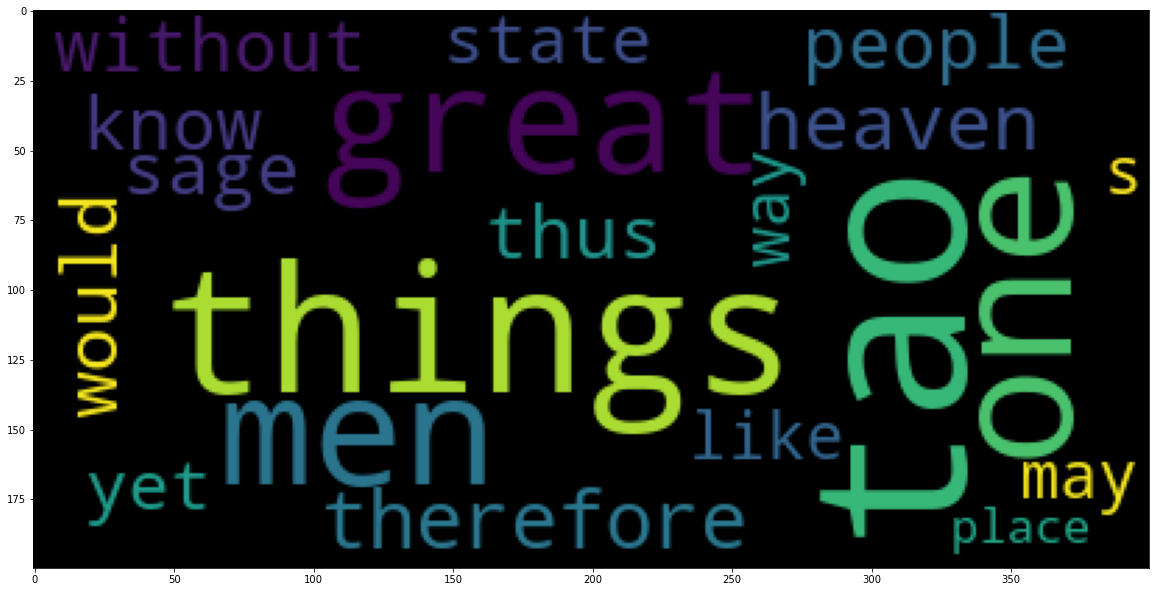

In [124]:
# Word cloud visualizations (ready for graphing)

# for all books in total
desc = all_20[:20].index.tolist(); counts = all_20[:20].tolist()
wordcloud_20 = WordCloud(max_words = 20).generate_from_frequencies(dict(zip(desc,counts))) # stored here

# for each book (in a list)
word_cloud_each = [] # all in this list
for i in top_20_books:
    desc = i[:20].index.tolist(); counts = i[:20].tolist()
    word_cloud_each.append(WordCloud(max_words = 20).generate_from_frequencies(dict(zip(desc,counts))))



In [83]:


# Instantiates a client
client = language_v1.LanguageServiceClient()

# The text to analyze
text = "Hello, world!"
document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment

print("Text: {}".format(text))
print("Sentiment: {}, {}".format(sentiment.score, sentiment.magnitude))

Text: Hello, world!
Sentiment: 0.6000000238418579, 0.6000000238418579


In [44]:
import io
import os

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="lustrous-center-305403-e1dd08c2ab3c.json"



def sample_analyze_sentiment(text_content):
    """
    Analyzing Sentiment in a String

    Args:
      text_content The text content to analyze
    """

    client = language_v1.LanguageServiceClient()

   

    # Available types: PLAIN_TEXT, HTML
    type_ = language_v1.Document.Type.PLAIN_TEXT

    # Optional. If not specified, the language is automatically detected.
    # For list of supported languages:
    # https://cloud.google.com/natural-language/docs/languages
    language = "en"
    document = {"content": text_content, "type_": type_, "language": language}

    # Available values: NONE, UTF8, UTF16, UTF32
    encoding_type = language_v1.EncodingType.UTF8

    response = client.analyze_sentiment(request = {'document': document, 'encoding_type': encoding_type})
    # Get overall sentiment of the input document
    print(u"Document sentiment score: {}".format(response.document_sentiment.score))
    print(
        u"Document sentiment magnitude: {}".format(
            response.document_sentiment.magnitude
        )
    )
    # Get sentiment for all sentences in the document
    for sentence in response.sentences:
        print(u"Sentence text: {}".format(sentence.text.content))
        print(u"Sentence sentiment score: {}".format(sentence.sentiment.score))
        print(u"Sentence sentiment magnitude: {}".format(sentence.sentiment.magnitude))

    # Get the language of the text, which will be the same as
    # the language specified in the request or, if not specified,
    # the automatically-detected language.
    print(u"Language of the text: {}".format(response.language))
    
text = 'I love my wife I love my life'
sample_analyze_sentiment(text)

Document sentiment score: 0.8999999761581421
Document sentiment magnitude: 0.8999999761581421
Sentence text: I love my wife I love my life
Sentence sentiment score: 0.8999999761581421
Sentence sentiment magnitude: 0.8999999761581421
Language of the text: en


In [247]:
data_train.describe()
                

,foolishness,hath,wholesome,takest,feelings,anger,vaivaswata,matrix,kindled,convict,...,erred,thinkest,modern,reigned,sparingly,visual,thoughts,illumines,attire,explains
count,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,...,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000
mean,0.003390,0.566102,0.006780,0.001695,0.032203,0.059322,0.001695,0.001695,0.006780,0.001695,...,0.003390,0.006780,0.003390,0.001695,0.001695,0.001695,0.079661,0.008475,0.005085,0.003390
std,0.058173,1.777487,0.082129,0.041169,0.488211,0.326851,0.041169,0.041169,0.082129,0.041169,...,0.058173,0.100701,0.058173,0.041169,0.041169,0.041169,0.366824,0.091744,0.071186,0.058173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,14.000000,1.000000,1.000000,11.000000,4.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000


# 2. Visualizations

In [236]:
total_words_book

{'Buddhism': 6624,
 'TaoTeChing': 4608,
 'Upanishad': 6579,
 'YogaSutra': 12443,
 'BookOfProverb': 7716,
 'BookOfEcclesiastes': 2773,
 'BookOfEccleasiasticus': 14839,
 'BookOfWisdom': 5027}

0           Buddhism_Ch1
1           Buddhism_Ch2
2           Buddhism_Ch3
3           Buddhism_Ch4
4           Buddhism_Ch5
             ...        
585    BookOfWisdom_Ch15
586    BookOfWisdom_Ch16
587    BookOfWisdom_Ch17
588    BookOfWisdom_Ch18
589    BookOfWisdom_Ch19
Name: Chapters, Length: 590, dtype: object